# Étude de cas n°2 - Estimation de volume cérébrospinal

L'objectif de ce TP est d'estimer au mieux le volume de liquide cérébrospinal à partir de scans IRM. On cherchera à reconstruire l'image en 3D afin de visualiser correctement les volumes que l'on mesure. Nous chercherons à mesurer le volume cérébrospinal total $V_T$, ainsi que le sous-volume de l'espace ventriculaire $V_V$. Ces deux mesures nous permettront de calculer le rapport $\frac{V_V}{V_T}$, ce qui nous permettra de détecter les patients atteints d'hydrocéphalie.

## Contexte médical

L’hydrocéphalie est une pathologie caractérisée par une accumulation excessive de liquide cérébrospinal (LCS) dans les cavités ventriculaires du cerveau. Elle peut entraîner une augmentation de la pression intracrânienne et engendrer divers symptômes, notamment :
- Des maux de tête ;
- Des troubles cognitifs ;
- Et dans les cas graves, des lésions cérébrales irréversibles.

Ce déséquilibre est souvent quantifiable par une augmentation significative du rapport $\frac{V_V}{V_T}$

## Méthodologie

### 1. Reconstruction 3D
Pour analyser aux mieux les données, les images IRM sagittales fournies seront utilisées dans un premier temps pour reconstruire un modèle 3D. Cette étape nous permettra d'obtenir une vue globale de la distribution du LCS ainsi qu'identifier les zones d’intérêt (ventricules, espace sous-arachnoïdien, colonne vertébrale et artefacts/bruits).

### 2. Calcul des volumes
Les volumes $V_T$ et $V_V$ seront obtenus en sommant l'intensité normalisées les voxels appartenant aux différentes régions, multipliés par le volume physique représenté par un voxel (à savoir : 0.9765635 × 0.9765635 × 1 $mm^3$)
Les algorithmes et méthodes utilisés pour arriver à extraire uniquement le LCS de l'espace ventriculaire sont détaillés plus loin.

### 1. Reconstruction 3D

Après avoir essayer plusieurs librairies Python pour reconstruire nos images en 3D, nous avons décidé d'utiliser pyvista

NB : Normalement, il est possible de naviguer dans les figures 3D dans ce notebook. Si ce n'est pas le cas, veuillez excécuter les programmes .py

In [1]:
import pyvista as pv
import numpy as np
from skimage import io
import math
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve
from skimage.segmentation import flood
from scipy.signal import savgol_filter, find_peaks

In [ ]:
# Constants
color_map = 'turbo' # Meilleur CMAP pour observer des contrastes à mon sens
voxel_volume_mm3 = 0.9765635 * 0.9765635 * 1  # Volume of a voxel in mm^3

# Notre dataset ne contient que 5 scans IRM :
path_sain = '../data/csf.tif'
path_malade = '../data/csf2.tif'
path_patient_inconnu_1 = '../data/c001.tif'
path_patient_inconnu_2 = '../data/c002.tif'
path_patient_inconnu_3 = '../data/c003.tif'

NB : Les fonctions ont été rédigées manuellement, mais ont été données à ChatGPT pour ajouter les descriptions afin d'améliorer leur clareté.

La première étape consiste tout d'abord à vérifier que l'on peut visualiser correctement en 2D.

In [4]:
def show_slice(path, slice_index):
    """
    Affiche une tranche spécifique d'une image 3D avec une colormap.

    Args:
        file_path (str): Chemin du fichier contenant l'image 3D (stack de tranches 2D).
        slice_index (int): Indice de la tranche à afficher.

    Raises:
        ValueError: Si l'indice de tranche est hors des limites de l'image.
    """
    # Charger l'image 3D (collection de tranches 2D)
    img = io.imread(path)
    
    # Vérifier que l'indice de la tranche est valide
    num_slices = img.shape[0]
    if not (0 <= slice_index < num_slices):
        raise ValueError(f"L'indice de tranche doit être compris entre 0 et {num_slices - 1}.")
    
    # Extraire la tranche désirée
    slice_2d = img[slice_index, :, :]
    
    # Affichage
    plt.figure(figsize=(6, 6))
    plt.imshow(slice_2d, cmap=color_map)
    plt.colorbar(label="Intensité") 
    plt.title(f'Tranche {slice_index}')
    plt.show()

In [5]:
show_slice(path_malade, 80)

FileNotFoundError: [Errno 2] No such file or directory: '/home/fred/Documents/TP_Lebret/IRM/IRM_Gabin/IRM/data/csf2.tif'

In [5]:
# Fonction pour charger une image 3D à partir d'un fichier
def load_image_3D(file_path):
    """
    Charge une image 3D depuis un fichier et la convertit en tableau NumPy de type float32.

    Args:
        file_path (str): Chemin du fichier image à charger.

    Returns:
        np.ndarray: Image 3D sous forme de tableau NumPy en float32.
    """
    image = io.imread(file_path)
    return image.astype(np.float32)


# Fonction pour visualiser une ou plusieurs images en 3D avec PyVista
def visualize_images_3D(volumes, titles):
    """
    Affiche une ou plusieurs images 3D et permet de naviguer dedans avec PyVista.

    Args:
        volumes (list of np.ndarray or list of pv.DataSet): Liste des volumes 3D à afficher.
        titles (list of str): Liste des titres associés aux volumes.

    Raises:
        ValueError: Si aucune image n'est fournie ou si le nombre de titres ne correspond pas.
    """
    num_volumes = len(volumes)
    if num_volumes == 0:
        raise ValueError("Aucun volume 3D fourni pour l'affichage.")

    if len(titles) != num_volumes:
        raise ValueError("Le nombre de titres doit correspondre au nombre de volumes.")

    # Détermination du nombre de lignes et colonnes pour l'affichage en grille
    cols = math.ceil(math.sqrt(num_volumes))
    rows = math.ceil(num_volumes / cols)
    
    # Création du visualiseur PyVista
    plotter = pv.Plotter(shape=(rows, cols))
    
    # Ajout de chaque volume dans son propre sous-graphique
    for i, (volume, title) in enumerate(zip(volumes, titles)):
        if not isinstance(volume, pv.DataSet):
            volume = pv.wrap(volume)  # Conversion en DataSet PyVista
            
        row, col = divmod(i, cols)  # Calcul de la position en grille
        plotter.subplot(row, col)
        plotter.add_volume(volume, cmap=color_map, opacity="sigmoid_6", name=title)
        plotter.add_text(title, font_size=10, position="upper_left")

    plotter.show()


# Fonction pour sauvegarder un volume 3D au format NumPy
def save_volume(volume, file_path):
    """
    Sauvegarde un volume 3D sous forme de fichier NumPy (.npy).

    Args:
        volume (np.ndarray or pv.DataSet): Volume 3D à sauvegarder.
        file_path (str): Chemin du fichier de sauvegarde.

    Notes:
        Utile pour éviter de retraiter des volumes volumineux et optimiser le temps de calcul.
    """
    if isinstance(volume, pv.DataSet):
        volume = volume.point_data.active_scalars.reshape(volume.dimensions, order="F")

    np.save(file_path, volume)
    print(f"Volume sauvegardé sous '{file_path}'.")


def calculate_volume(img_float):
    """
    Calcule le volume total des voxels d'un liquide dans une image 3D
    en fonction d'un seuil d'intensité.
    
    Paramètres:
    - img_float : Image 3D (type pyvista.DataSet ou numpy array) avec des intensités de voxels.

    Retour:
    - Volume en mm^3, arrondi à 2 décimales.
    """
    
    # Seuil d'intensité à partir duquel on considère que c'est du LCS
    threshold = 45
    if isinstance(img_float, pv.DataSet):
        img_float = img_float.point_data.active_scalars.reshape(img_float.dimensions, order="F")
    liquid_voxels = np.sum(img_float > threshold)
    
    # Calculer le volume total des voxels liquides en multipliant par le volume d'un voxel
    volume_mm3 = liquid_voxels * voxel_volume_mm3
    return round(volume_mm3, 2)


In [6]:
patient_sain_raw = load_image_3D(path_sain)
patient_malade_raw = load_image_3D(path_malade)
volumes_3D = [patient_sain_raw, patient_malade_raw]
titles = ["patient sain", "patient malade"]
visualize_images_3D(volumes_3D, titles)

Widget(value='<iframe src="http://localhost:49445/index.html?ui=P_0x141a4ea6300_0&reconnect=auto" class="pyvis…

# Extraction du volume de l'espace ventriculaire

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

def sum_slices_intensity(file_path, intensity_threshold=0):
    """
    Calcule la somme des intensités des pixels sur toutes les tranches d'une image 3D 
    et applique un seuil pour filtrer les faibles intensités.

    Args:
        file_path (str): Chemin du fichier contenant l'image 3D (stack de tranches 2D).
        intensity_threshold (float, optional): Seuil minimal pour conserver une intensité (défaut: 0).

    Returns:
        np.ndarray: Image 2D représentant la somme des intensités des pixels filtrée.
    """
    # Chargement de l'image 3D (stack de tranches 2D)
    img = io.imread(file_path)
    
    # Somme des intensités pixel par pixel à travers toutes les tranches
    img_sum = np.sum(img, axis=0)

    # Application du seuil d'intensité
    img_sum_filtered = np.where(img_sum >= intensity_threshold, img_sum, 0)
    
    # Affichage du résultat
    plt.figure(figsize=(6, 6))
    plt.imshow(img_sum_filtered, cmap='turbo')
    plt.colorbar(label="Intensité cumulée")
    plt.title("Somme des intensités des pixels\nsemblables (i.e. (x,y) identiques)")
    plt.axis('off')  # Suppression des axes pour une meilleure lisibilité
    plt.show()

    return img_sum_filtered


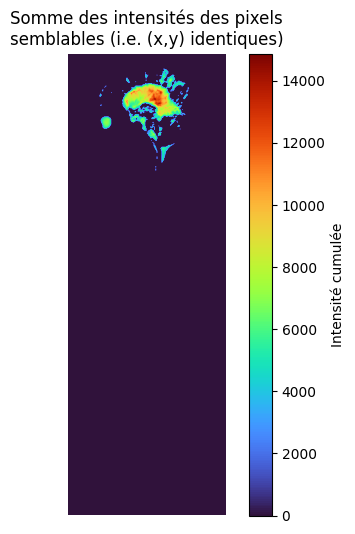

In [8]:
img_sum_filtered = sum_slices_intensity(path_malade, 4000)

Cette première approche, nous a permi de constater que le maximum d'intensité se trouvait systèmatiquement dans l'espace sous-ventriculaire (parfois dans les yeux mais ils seront retirés par la suite).
De plus, on constate (sur la visualisation 3D) que les voxels associés à cette zone sont relativement "similaires" (i.e. ils ont l'air de se ressembler)... cohérent étant donné qu'ils appartiennet à une même zone.
Ainsi, la première méthode que nous avons explorée pour extraire le volume sous-ventriculaire est le "region growing".

# Méthode du Region Growing

La méthode du *Region Growing* est une technique de segmentation d'image qui permet d'extraire des zones homogènes dans un volume 3D à partir d'un point de départ, appelé la graine (*seed*). Elle repose sur l'idée que les voxels voisins ayant des caractéristiques similaires (comme l'intensité ou d'autres propriétés) appartiennent à la même région.

### Principe

On commence par placer une graine dans le volume à un emplacement donné dans la région que l'on souhaite extraire. À partir de cette graine, l'algorithme "explore" les voisins de cette seed. Pour chaque voxel voisin, on calcule la différence d'intensité par rapport à la graine ou aux voxels déjà inclus dans la région. Si cette différence d'intensité est inférieure à un certain seuil (appelé *threshold*), le voxel est ajouté à la région en croissance. Puis, l'algorithme continue de cette manière, explorant de nouveaux voxels voisins et les ajoutant à la région, tant qu'ils satisfont au critère de similarité.

### Seuil de Similarité

Le seuil est un paramètre crucial dans cette méthode. Si le seuil est trop bas, l'algorithme pourrait inclure des voxels qui ne font pas réellement partie de la région d'intérêt. À l'inverse, un seuil trop élevé pourrait limiter la région à des zones trop petites, omettant des voxels pertinents.


### Lissage gaussien

Pour faciliter l'ajout de volex semblable à la seed, l'ajout d'un lissage Gaussien sur le volume initiale augmente fortement ses performances. 
Ceci est cohérent car après lissage on harmonise nos valeurs d'intensités et on limite les effets de bruits ou de "singularité".

In [9]:
# Fonction pour trouver le point de plus haute intensité dans un volume 3D
def find_max_intensity_point(volume):
    """
    Trouve la position du voxel ayant la plus grande somme locale d'intensité dans un volume 3D.
    
    Utilise une matrice de convolution (3x3x3 par défaut) pour lisser les intensités 
    et repérer la région de plus forte intensité.

    Args:
        volume (np.ndarray): Volume 3D en entrée.

    Returns:
        tuple: Coordonnées (z, y, x) du point de plus forte intensité.
    """
    kernel = np.ones((3, 3, 3))  # Taille ajustable, 3x3x3 fonctionne bien pour nos données
    local_sums = convolve(volume, kernel, mode='constant', cval=0)
    max_position = np.unravel_index(np.argmax(local_sums), local_sums.shape)
    return max_position


# Fonction pour appliquer un lissage Gaussien à un volume 3D
def gaussian_filter_volume(volume, sigma=1.5):
    """
    Applique un filtre Gaussien pour lisser un volume 3D.

    Args:
        volume (np.ndarray): Volume 3D à filtrer.
        sigma (float, optional): Écart-type du filtre Gaussien (par défaut 1.5).

    Returns:
        np.ndarray: Volume 3D filtré.
    """
    return gaussian_filter(volume, sigma=sigma)


# Fonction de segmentation par croissance de région ("region growing")
def region_growing(volume_filtered, seed_point, tolerance=10):
    """
    Applique l'algorithme de croissance de région à un volume 3D filtré.

    Args:
        volume_filtered (np.ndarray): Volume 3D lissé à segmenter.
        seed_point (tuple): Coordonnées (z, y, x) du point de départ.
        tolerance (float, optional): Seuil de tolérance pour la segmentation (par défaut 10).

    Returns:
        np.ndarray: Volume 3D segmenté.
    """
    return flood(volume_filtered, seed_point, tolerance=tolerance)


# Fonction pour normaliser l'intensité dans un volume 3D
def normalize_volume_intensity(volume):
    """
    Normalise l'intensité des voxels d'un volume 3D entre 0 et 1.

    Args:
        volume (np.ndarray): Volume 3D à normaliser.

    Returns:
        np.ndarray: Volume 3D normalisé.
    """
    max_intensity = np.max(volume)
    return volume / max_intensity if max_intensity > 0 else volume


# Fonction pour remplacer les voxels non nuls par ceux d'un autre volume
def replace_non_zero_voxels(volume1, volume2):
    """
    Remplace les voxels non nuls de volume1 par ceux de volume2.

    Args:
        volume1 (np.ndarray or pv.DataSet): Volume de référence avec certains voxels à remplacer.
        volume2 (np.ndarray or pv.DataSet): Volume contenant les nouvelles valeurs.

    Returns:
        np.ndarray or pv.DataSet: Volume résultant avec les valeurs mises à jour.
    """
    # Conversion en tableau NumPy si nécessaire
    if isinstance(volume1, pv.DataSet):
        volume1_data = volume1.point_data.active_scalars.reshape(volume1.dimensions, order="F")
    else:
        volume1_data = volume1

    if isinstance(volume2, pv.DataSet):
        volume2_data = volume2.point_data.active_scalars.reshape(volume2.dimensions, order="F")
    else:
        volume2_data = volume2

    # Vérification des dimensions
    assert volume1_data.shape == volume2_data.shape, "Les deux volumes doivent avoir les mêmes dimensions."

    # Remplacement des valeurs non nulles
    volume_resultant = np.where(volume1_data != 0, volume2_data, volume1_data)

    # Conversion en DataSet PyVista si nécessaire
    return pv.wrap(volume_resultant) if isinstance(volume1, pv.DataSet) else volume_resultant

def process_volume_for_segmentation(volume, tolerance=0.3):
    # 1. Normalisation de l'intensité du volume d'entrée
    volume_normalise = normalize_volume_intensity(volume)

    # 2. Application du filtre Gaussien pour lisser le volume
    sigma_gaussien = 1.5 # Cette valeur a été choisi relativement faible, 
                         # car une valeur trop élevé entrainte une uniformisation
                         # trop grande pour que le région growing fonctionne correctement
    volume_lisse = gaussian_filter_volume(volume_normalise, sigma=sigma_gaussien)

    # 3. Recherche du point d'intensité maximale pour la segmentation (seed)
    seed = find_max_intensity_point(volume_lisse)
    print(f"Point d'intensité maximale (seed) : {seed}")

    # 4. Segmentation par croissance régionale à partir de la seed
    volume_segmente = region_growing(volume_lisse, seed, tolerance=tolerance)

    # 5. Conversion du volume segmenté en format PyVista (si nécessaire)
    volume_segmente_pv = pv.wrap(volume_segmente.astype(np.float32))

    # 6. Remplacement des voxels non nuls par les valeurs du volume original.
    volume_resultant = replace_non_zero_voxels(volume_segmente_pv, volume)
    return volume_resultant

In [10]:
volume_ventriculaire_malade = process_volume_for_segmentation(patient_malade_raw)
volume_ventriculaire_sain = process_volume_for_segmentation(patient_sain_raw, tolerance = 0.43)
visualize_images_3D([volume_ventriculaire_sain, volume_ventriculaire_malade], ["Volume ventriculaire patient sain", "Volume ventriculaire patient malade"])


Point d'intensité maximale (seed) : (71, 94, 138)
Point d'intensité maximale (seed) : (83, 81, 132)


Widget(value='<iframe src="http://localhost:49445/index.html?ui=P_0x141c457dca0_1&reconnect=auto" class="pyvis…

Les valeurs obtenues correspondent bien aux ordres de grandeurs que l'on peut trouver dans la littérature (voir résultats à la fin).

Inconvénient de cette méthode : le seuil de tolérance doit être ajusté correctement pour chaque patient. S'il est mal reglé les résultats obtenus deviennent chaotiques (cf. ci-dessous) :
- seuil trop faible : le volume ne grandit pas suffisemment
- seuil trop élevé  : le volume s'étent au delà du volume ventriculaire de manière incontrolée

In [11]:
tolerance_values = [0.1, 0.3, 0.5, 0.6]
volumes_3D = []
labels = []
for tolerance in tolerance_values:
    volumes_3D.append(process_volume_for_segmentation(patient_malade_raw, tolerance))
    labels.append(f"tolerance = {tolerance}")

visualize_images_3D(volumes_3D,labels)

Point d'intensité maximale (seed) : (71, 94, 138)
Point d'intensité maximale (seed) : (71, 94, 138)
Point d'intensité maximale (seed) : (71, 94, 138)
Point d'intensité maximale (seed) : (71, 94, 138)


Widget(value='<iframe src="http://localhost:49445/index.html?ui=P_0x141b34cf0e0_2&reconnect=auto" class="pyvis…

# Ajustement automatique du seuil de tolerance

La partie difficile de cette méthode consiste donc à trouver un moyen fiable et peu couteux en calcul (de préférence) pour ajuster correctement ce seuil de tolérance pour chaque patient. La première idée que nous avons eu a été de voir s'il n'y avait pas une corrélation entre le volume total (au niveau du crâne) et ce seuil de tolérance. En effet, on s'attendait à ce que ce seuil augmente lorsque le volume ventriculaire fait de même. Cette réflexion supposait que plus le nombre de volexs compris dans l'espace ventriculaire est grand, plus ces volexs s'étalent dans l'espace et peuvent s'avérer différents de la seed. Or, nous n'avvons pas pu dégager cette tendance d'après notre dataset.

Une autre méthode classique explorée a été d'analyser le volume obtenue par Region Growing en fonction du seuil. Cette méthode est certe couteuse en calcul mais les premières courbes obtenues sont encourageantes (cf. ci-dessous). Malheuresement, l'automatisation du seuil par cette méthode n'a pas aboutie, bien que l'on pense que cela soit possible (manque de temps pour ce plonger d'avantages dans cette méthode).

Ainsi, malgré de nombreux tests aucune méthode classique n'a fonctionnée pour automatiser cette valeur du seuil. Ceci s'explique notamment par les nombreuses patologies qui exsitent. Une autre solution serait d'implémenter de l'IA malheuresement nous n'avions pas une base de données assez grande pour entrainer un modèle (que ce soit par reconnaissance de forme, ou de type CNN).

In [12]:
sigma_gaussien = 1.5
image_normalisee = normalize_volume_intensity(patient_sain_raw)
volume_lisse = gaussian_filter_volume(image_normalisee, sigma=sigma_gaussien)
seed = find_max_intensity_point(volume_lisse)

volume_list = []
tolerance_value_list = np.linspace(0.1, 0.5, 30)
for tolerance in tolerance_value_list:
    tolerance_croissance = tolerance
    volume_segmente = region_growing(volume_lisse, seed, tolerance=tolerance_croissance)
    volume_segmente_pv = pv.wrap(volume_segmente.astype(np.float32))
    volume_ventriculaire_malade_ = replace_non_zero_voxels(volume_segmente_pv, patient_sain_raw)
    volume_malade_ventriculaire_mm3 = calculate_volume(volume_ventriculaire_malade_)
    volume_list.append(volume_malade_ventriculaire_mm3)

# Valeur pour le seuil retenu à la main
tolerance_croissance = 0.43
volume_segmente = region_growing(volume_lisse, seed, tolerance=tolerance_croissance)
volume_segmente_pv = pv.wrap(volume_segmente.astype(np.float32))
volume_ventriculaire_malade_ = replace_non_zero_voxels(volume_segmente_pv, patient_sain_raw)
volume_malade_ventriculaire_mm3 = calculate_volume(volume_ventriculaire_malade_)
volume_conserve = volume_malade_ventriculaire_mm3

# Conversion des listes en tableaux numpy
tolerance_array = np.array(tolerance_value_list)
volume_array = np.array(volume_list)

# Calcul de la dérivée discrète
    # Cette dérivée pourra être utilisé pour de la détection de pic
derivatives = np.diff(volume_array) / np.diff(tolerance_array)
derivative_x = (tolerance_array[:-1] + tolerance_array[1:]) / 2




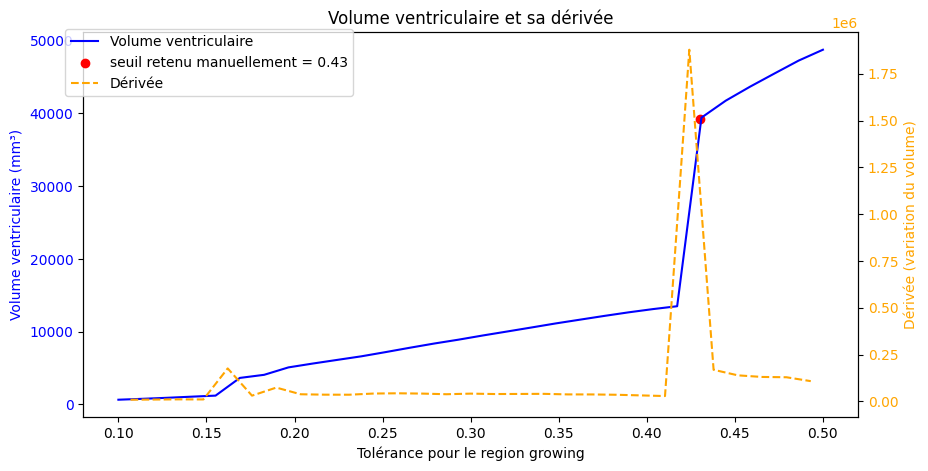

In [13]:
# Création de la figure et des axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Premier axe : volume ventriculaire
ax1.plot(tolerance_array, volume_array, label="Volume ventriculaire", color='b')
ax1.scatter([0.43], [volume_conserve], color='red', label="seuil retenu manuellement = 0.43")
ax1.set_xlabel("Tolérance pour le region growing")
ax1.set_ylabel("Volume ventriculaire (mm³)", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Deuxième axe : dérivée
ax2 = ax1.twinx()
ax2.plot(derivative_x, derivatives, label="Dérivée", color='orange', linestyle='dashed')
ax2.set_ylabel("Dérivée (variation du volume)", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Ajout des légendes
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.title("Volume ventriculaire et sa dérivée")

plt.show()

On constate que la courbe obtenue est toujours une sucession (+ ou -) portion linéaire, où chaque portion correspond à des zones précise. Il suffit donc de savoir quelle portion correspond à la fin du volume ventriculaire.
Ici, pour un patient sain on dénombre 3 zones linaires ce qui est relativement facile. Or pour un patient malade, le nombre de zones augmente selon les pathologies + étant donné que l'on utilise une seule seed la croissance peut se faire simultanément sur différentes régions du cerveau ==> on peut inclure à force de s'étendre des régions qui ne font pas partie du volume ventriculaire ==> pour les malades le seuil est généralement dans une zone linéaire et non à l'extrémité.

# Extraction du volume total

Pour l'extraction du volume total, il est necéssaire de filtrés certains éléments :
- les yeux
- la vessie 
- les volexs associés aux tissus ou organes du corps

# Les yeux 
Le volume de l'œil humain moyen est d'environ 6 à 7 millilitres (mL). Plus précisément, il est généralement estimé à environ 6.5 mL. Cela inclut l'ensemble de la structure oculaire, y compris la cornée, le cristallin, le corps vitré, et la rétine. Ainsi, lors d'un scan IRM, ce volume devrait rester relativement constant, sauf en présence de conditions pathologiques.

Il suffira donc de soustraire ce volume à chaque fois.

# Tissus/organes et vessie
On observe que certains scans IRM présentent des volexs parasites. Ceci peuvent principalement être filtré par seuillage ==> seuil à 45. Cette valeur de seuil est obtenus par rapport à ce que l'on souhaite mesurer : du liquide cérébrospinale qui est composé principalement d'eau qui sur un IRM ne peut pas vraiment descendre en dessous de ces valeurs.

Cependant, un problème émerge pour la vessie qui peut contenir beaucoup d'eau et donc apparaitre avec une forte intensité sur notre scan IRM.
Pour résoudre ce problème, on regarde la densité d'intensité selon les axes x,y,z. En effet, au niveau de la colonne vertébrale (si le patient est correctement positionner), la densité devrait être plus ou moins constant. Ainsi, on devrait observer un pics d'intensité lorsque l'on arrive au niveau de la vessie ==> on coupe le volume à ce niveau là.



In [14]:
# Fonction pour filtrer les volexs en dessous d'un certains seuil (ici fixer à 60)
def threshold_volume(volume, threshold=60):
    filtered_volume = np.where(volume >= threshold, volume, 0)
    return filtered_volume

# Appliquer le filtrage sur les volumes des patients
volume_sain_filtered = threshold_volume(patient_sain_raw, threshold=60)
volume_malade_filtered = threshold_volume(patient_malade_raw, threshold=60)

# Affichage des volumes filtrés
volumes_3D = [volume_sain_filtered, volume_malade_filtered]
titles = ["Patient Sain (Filtré)", "Patient Malade (Filtré)"]
visualize_images_3D(volumes_3D, titles)


Widget(value='<iframe src="http://localhost:49445/index.html?ui=P_0x141cbf489b0_3&reconnect=auto" class="pyvis…

Ici le filtrage retire même correctement la vessie, cependant sur d'autre scan IRM cela ne suffit, d'où la méthode expliquée précédemment.

In [15]:

def visualize_density_projections(volume_3D):
    # Projections sur les axes X, Y, Z
    x_density = np.sum(volume_3D, axis=0)
    y_density = np.sum(volume_3D, axis=1)
    z_density = np.sum(volume_3D, axis=2)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(x_density, cmap='viridis', origin='lower')
    axes[0].set_title("Projection sur le plan YZ (axe X)")
    axes[0].set_xlabel("Y")
    axes[0].set_ylabel("Z")

    axes[1].imshow(y_density, cmap='plasma', origin='lower')
    axes[1].set_title("Projection sur le plan XZ (axe Y)")
    axes[1].set_xlabel("X")
    axes[1].set_ylabel("Z")

    axes[2].imshow(z_density, cmap='inferno', origin='lower')
    axes[2].set_title("Projection sur le plan XY (axe Z)")
    axes[2].set_xlabel("X")
    axes[2].set_ylabel("Y")

    plt.tight_layout()
    plt.show()

def derivative(points, dx=1):
    return np.abs(np.diff(points) / dx)

def plot_envelope(data, threshold=None, window_length=51, polyorder=3, color='green'):

    # Si un seuil est donné, on filtre les valeurs délirantes
    if threshold is not None:
        filtered_data = np.where(data < threshold, data, np.nan)
    else:
        filtered_data = data

    # Lissage de l'enveloppe avec le filtre de Savitzky-Golay
    smooth_data = savgol_filter(filtered_data, window_length=window_length, polyorder=polyorder, mode='nearest')
    
    # Tracer les données originales
    plt.plot(data, color='gray', alpha=0.5, label='Données originales')
    
    # Tracer l'enveloppe supérieure lissée
    plt.plot(smooth_data, color=color, label='Enveloppe lissée', linewidth=2)
    plt.title("Enveloppe supérieure des points")
    plt.xlabel("Index")
    plt.ylabel("Valeur")
    plt.legend()
    plt.show()

def visualize_density_along_axes(volume_3D, show = True):
    # Somme sur les plans perpendiculaires aux axes
    x_density = np.sum(np.sum(volume_3D, axis=1), axis=1)
    y_density = np.sum(np.sum(volume_3D, axis=0), axis=1)
    z_density = np.sum(np.sum(volume_3D, axis=0), axis=0)
    
    # On regarde plutôt les dérivées car on cherche un changement brusque dans la densité en intensité
    x_derivative = np.abs(derivative(x_density))
    y_derivative = np.abs(derivative(y_density))
    z_derivative = np.abs(derivative(z_density))
    
    if show :
        plt.figure(figsize=(15,3))
        plt.subplot(1, 3, 1)
        plt.plot(x_derivative, color='blue')
        plt.title("dX")
        plt.xlabel("X")
        plt.ylabel("Densité")

        plt.subplot(1, 3, 2)
        plt.plot(y_derivative, color='red')
        plt.title("dY")
        plt.xlabel("Y")
        plt.ylabel("Densité")
        
        
        plt.subplot(1, 3, 3)
        plt.plot(z_derivative, color='green')
        plt.title("dZ")
        plt.xlabel("Z")
        plt.ylabel("Densité")

        plt.tight_layout()
        plt.show()

        plt.tight_layout()
        plt.show()
    return y_derivative



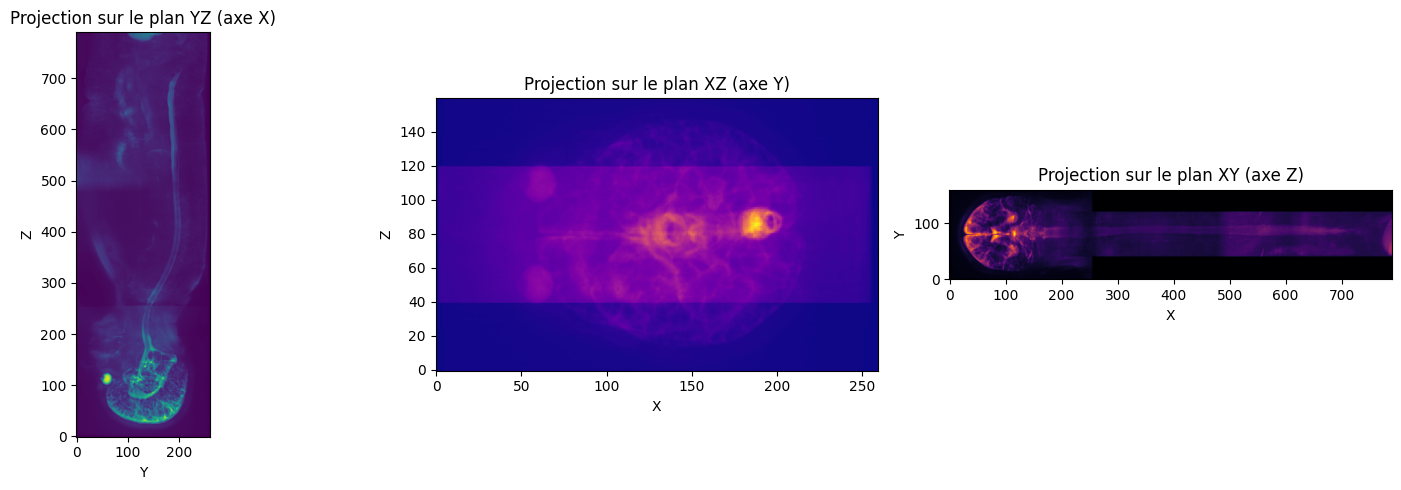

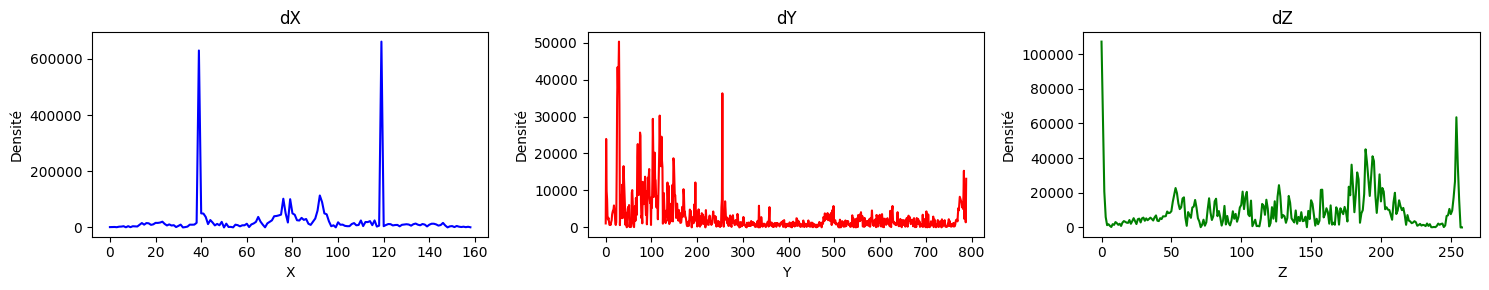

<Figure size 640x480 with 0 Axes>

In [16]:
visualize_density_projections(patient_sain_raw)
Ddensite_y_sain = visualize_density_along_axes(patient_sain_raw)

Les graphes sont plutôt intéressants car permettent de visualiser de nombreux éléments:
- graphe dX : on observe bien deux pics correspondant à l'entrée et la sortie dans le volume ventriculaire. Ils sont particulièrement visible car il s'agit d'un patient sain
- graphe dY : on observe bien un palier correspondant à la colonne vertébrale (i.e. intensité constante) puis un pics lorsque l'on arrive à la vessie
- graphe dZ : on observe les yeux qui se traduisent par une augmentation de la densité en intensité (tranche 250)

In [25]:
# On cherche le dernier pic dans la densité en intensité sur l'axe Y :
    # S'il dépasse un certain index (i.e. aprés le début du plateau de la colonne vertébrale)
        # Alors c'est qu'il s'agit du pic associé à la vessie

def find_last_density_pic(Ddensite_y, show=True):
    """Trouve le dernier pic dans une courbe de densité avec un seuil de hauteur de 10000."""
    peaks, _ = find_peaks(Ddensite_y, height=10000)

    if len(peaks) > 0:
        last_peak = peaks[-1]

        # Visualisation de la courbe et du dernier pic
        if show:
            plt.figure(figsize=(15, 3))
            plt.plot(Ddensite_y, color='blue', label="Densité")
            plt.plot(last_peak, Ddensite_y[last_peak], "ro", label="Dernier Pic détecté")
            plt.title("Détection du Dernier Pic (Seuil de Hauteur 10000)")
            plt.xlabel("X")
            plt.ylabel("Densité")
            plt.legend()
            plt.show()

        print(f"Index du dernier pic : {last_peak}")
        return last_peak  # Retourne l'index du dernier pic
    
    print("Aucun pic détecté avec ce seuil.")
    return None  # Aucun pic détecté


def cut_volume_below_y(volume_3d, threshold):
    """Remplace par 0 les voxels en dessous d'un seuil Y donné."""
    volume_cropped = volume_3d.copy()
    volume_cropped[:, threshold:, :] = 0  
    return volume_cropped


def crop_volume_if_needed(patient_raw, show=True):
    """Si un pic est détecté après 700, coupe le volume à partir de ce point."""
    Ddensite_y = visualize_density_along_axes(patient_raw, show=False)
    last_peak_index = find_last_density_pic(Ddensite_y, show)

    # Vérifier si un pic a été trouvé et s'il est supérieur à 700
    if last_peak_index is not None and last_peak_index > 700:
        start_peak = max(0, last_peak_index - 30)  # Évite les indices négatifs
        return cut_volume_below_y(patient_raw, start_peak)
    
    # Sinon, on retourne le volume tel quel
    return patient_raw




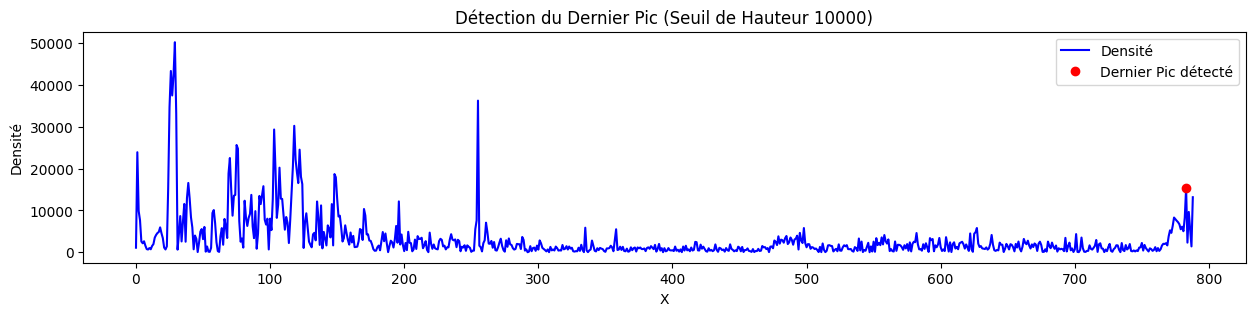

Index du dernier pic : 783


Widget(value='<iframe src="http://localhost:49445/index.html?ui=P_0x141cbf21550_4&reconnect=auto" class="pyvis…

In [18]:
volume_sain_sans_vessie = crop_volume_if_needed(patient_sain_raw)
volume_sain_filtered = threshold_volume(volume_sain_sans_vessie)
visualize_images_3D([volume_sain_filtered], ["Volume sain sans vessie"])


# Calcul des volumes :

Premirèe étape : mesurer le volume associé à un oeil.

In [19]:
volumes_LCS_mm3 = []

In [20]:
# On isole un oeil à partir des volumes raw
# Créer une copie du volume pour ne pas modifier l'original
volume_cropped = patient_sain_raw.copy()

# On utilise les seuils obtenue avec les densité en intensité obtenue précédemment que l'on ajuste pour ne garder qu'un seul oeil
volume_cropped[:, 0:100, :] = 0  # On remplace ces valeurs par 0 (ou une autre valeur pour les ignorer)
volume_cropped[:, 140:, :] = 0  # On remplace ces valeurs par 0 (ou une autre valeur pour les ignorer)
volume_cropped[65:, :, :] = 0  # On remplace ces valeurs par 0 (ou une autre valeur pour les ignorer)
volume_cropped[:, :, :45] = 0  # On remplace ces valeurs par 0 (ou une autre valeur pour les ignorer)
volume_cropped[:, :, 70:] = 0  # On remplace ces valeurs par 0 (ou une autre valeur pour les ignorer)

visualize_images_3D([volume_cropped], ["Volume des yeux modifié"])
volume_oeil_mm3 = calculate_volume(volume_cropped)
print(f"Volume d'un oeil = {volume_oeil_mm3} mm3")


Widget(value='<iframe src="http://localhost:49445/index.html?ui=P_0x141cd3373e0_5&reconnect=auto" class="pyvis…

Volume d'un oeil = 5608.57 mm3


On trouve une valeur de 5,6mL ce qui est cohérent avec les valeurs dans la littérature.

# Cas des patients inconnus

In [21]:
patient_1_raw = load_image_3D(path_patient_inconnu_1)
patient_2_raw = load_image_3D(path_patient_inconnu_2)
patient_3_raw = load_image_3D(path_patient_inconnu_3)

# Valeur des seuils estimer à partir du visuel + courbe (cf. méthode vu précédemment)
volume_ventriculaire_1 = process_volume_for_segmentation(patient_1_raw, 0.37)
volume_ventriculaire_2 = process_volume_for_segmentation(patient_2_raw, 0.30)
volume_ventriculaire_3 = process_volume_for_segmentation(patient_3_raw, 0.45)

visualize_images_3D([volume_ventriculaire_1, volume_ventriculaire_2, volume_ventriculaire_3], ["Patient 1", "Patient 2", "Patient 3"])

Point d'intensité maximale (seed) : (58, 149, 127)
Point d'intensité maximale (seed) : (83, 112, 157)
Point d'intensité maximale (seed) : (74, 106, 139)


Widget(value='<iframe src="http://localhost:49445/index.html?ui=P_0x141f2a467b0_6&reconnect=auto" class="pyvis…

In [26]:
volume_1_sans_vessie = crop_volume_if_needed(patient_1_raw, show=False)
volume_1_filtered = threshold_volume(volume_1_sans_vessie)

volume_2_sans_vessie = crop_volume_if_needed(patient_2_raw, show=False)
volume_2_filtered = threshold_volume(volume_2_sans_vessie)

volume_3_sans_vessie = crop_volume_if_needed(patient_3_raw, show=False)
volume_3_filtered = threshold_volume(volume_3_sans_vessie)

# visualize_images_3D([volume_1_filtered, volume_2_filtered, volume_3_filtered], ["Patient 1", "Patient 2", "Patient 3"])

Index du dernier pic : 861
Index du dernier pic : 720
Index du dernier pic : 868


# Résultats finaux

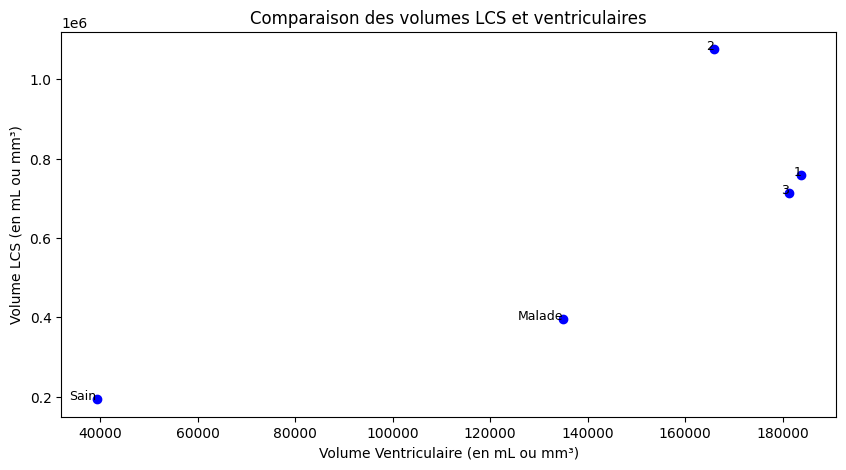

In [27]:

volume_LCS_sain_mm3 = calculate_volume(volume_sain_filtered) - 2 * volume_oeil_mm3
volume_LCS_malade_mm3 = calculate_volume(volume_malade_filtered) - 2 * volume_oeil_mm3
volume_LCS_1_mm3 = calculate_volume(volume_1_filtered) - 2 * volume_oeil_mm3
volume_LCS_2_mm3 = calculate_volume(volume_2_filtered) - 2 * volume_oeil_mm3
volume_LCS_3_mm3 = calculate_volume(volume_3_filtered) - 2 * volume_oeil_mm3

volumes_LCS_mm3 = []
volumes_LCS_mm3.append(volume_LCS_sain_mm3)
volumes_LCS_mm3.append(volume_LCS_malade_mm3)
volumes_LCS_mm3.append(volume_LCS_1_mm3)
volumes_LCS_mm3.append(volume_LCS_2_mm3)
volumes_LCS_mm3.append(volume_LCS_3_mm3)


volumes_ventriculaires_mm3 =[]
volumes_ventriculaires_mm3.append(calculate_volume(volume_ventriculaire_sain))
volumes_ventriculaires_mm3.append(calculate_volume(volume_ventriculaire_malade))
volumes_ventriculaires_mm3.append(calculate_volume(volume_ventriculaire_1))
volumes_ventriculaires_mm3.append(calculate_volume(volume_ventriculaire_2))
volumes_ventriculaires_mm3.append(calculate_volume(volume_ventriculaire_3))

# Liste de labels (par exemple "Sain" et "Malade")
labels = ['Sain', 'Malade', '1', '2', '3']

# On trace un graphique pour voir la répartition sain vs malade
plt.figure(figsize=(10, 5))
plt.scatter(volumes_ventriculaires_mm3, volumes_LCS_mm3, label="Volume LCS", marker='o', color='b')

# Ajouter les labels à chaque point
for i, label in enumerate(labels):
    plt.text(volumes_ventriculaires_mm3[i], volumes_LCS_mm3[i], label, fontsize=9, ha='right')

plt.title("Comparaison des volumes LCS et ventriculaires")
plt.xlabel("Volume Ventriculaire (en mL ou mm³)")
plt.ylabel("Volume LCS (en mL ou mm³)")

# Afficher le graphique
plt.show()


Valeurs cohérentes avec ce qui a pu être observer dans la littérature que ce soit pour la patient malade ou sain.
Les 3 patients inconnus semblent malades, ce qui étaient prévisibles lors des observations en 3D.